<a href="https://colab.research.google.com/github/BlozerX/BreakTheCaptcha/blob/main/pcgtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task-0

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


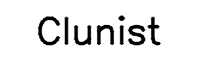

Easy Set Text: Clunist


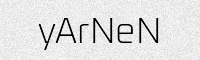

Hard Set Text: yArNeN


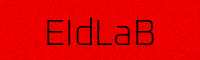

Bonus Set Ground Truth Text: BaLdIE


In [4]:
import cv2
import numpy as np
import random
import os
import nltk
nltk.download('words')
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont

font_list = [
    "/content/drive/MyDrive/GenFonts/EmilysCandy-Regular.ttf",
    "/content/drive/MyDrive/GenFonts/Homenaje-Regular.ttf",
    "/content/drive/MyDrive/GenFonts/Oxanium-VariableFont_wght.ttf",
    "/content/drive/MyDrive/GenFonts/RobotoMono-VariableFont_wght.ttf",
    "/content/drive/MyDrive/GenFonts/YatraOne-Regular.ttf"
]

wordList = list(set(words.words()))

def generate_captcha(text=None, img_width=200, img_height=60, set_type='easy'):

    if text is None:
        text = random.choice(wordList)

    img = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255

    if set_type == 'easy':
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.2
        thickness = 2
        text_color = (0, 0, 0)

        while True:
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
            if text_width < img_width - 20:
                break
            font_scale -= 0.1

        (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
        x = (img_width - text_width) // 2
        y = (img_height + text_height) // 2

        cv2.putText(img, text, (x, y), font, font_scale, text_color, thickness, cv2.LINE_AA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif set_type == 'hard':

        text = ''.join([c.upper() if random.random() > 0.5 else c.lower() for c in text])

        random_font = random.choice(font_list)
        font_size = random.randint(25, 40)
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        font_pil = ImageFont.truetype(random_font, font_size)
        bbox = draw.textbbox((0, 0), text, font=font_pil)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        while text_width > img_width - 20:
            font_size -= 2
            font_pil = ImageFont.truetype(random_font, font_size)
            bbox = draw.textbbox((0, 0), text, font=font_pil)
            text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        x = (img_width - text_width) // 2
        y = (img_height - text_height) // 2
        draw.text((x, y), text, font=font_pil, fill=(0, 0, 0))
        img = np.array(img_pil)

        noise = np.random.randint(0, 40, (img_height, img_width, 3), dtype=np.uint8)
        img = cv2.subtract(img, noise)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif set_type == 'bonus':
        text = ''.join([c.upper() if random.random() > 0.5 else c.lower() for c in text])
        original_text = text

        bonus_bg = random.choice(['green', 'red'])
        if bonus_bg == 'green':
            bg_color = (0, 255, 0)
            display_text = text
        else:
            bg_color = (0, 0, 255)
            display_text = text[::-1]

        img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
        img[:] = bg_color

        random_font = random.choice(font_list)
        font_size = random.randint(25, 40)

        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        font_pil = ImageFont.truetype(random_font, font_size)

        bbox = draw.textbbox((0, 0), display_text, font=font_pil)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        while text_width > img_width - 20:
            font_size -= 2
            font_pil = ImageFont.truetype(random_font, font_size)
            bbox = draw.textbbox((0, 0), display_text, font=font_pil)
            text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        x = (img_width - text_width) // 2
        y = (img_height - text_height) // 2

        draw.text((x, y), display_text, font=font_pil, fill=(0, 0, 0))

        img = np.array(img_pil)

        noise = np.random.randint(0, 40, (img_height, img_width, 3), dtype=np.uint8)
        img = cv2.subtract(img, noise)

        text = original_text

    return img, text

from google.colab.patches import cv2_imshow

easy_img, easy_text = generate_captcha(set_type='easy')
hard_img, hard_text = generate_captcha(set_type='hard')
bonus_img, bonus_text = generate_captcha(set_type='bonus')

cv2_imshow(easy_img)
print(f"Easy Set Text: {easy_text}")

cv2_imshow(hard_img)
print(f"Hard Set Text: {hard_text}")

cv2_imshow(bonus_img)
print(f"Bonus Set Ground Truth Text: {bonus_text}")

Dataset Generation

In [37]:
class ClassificationDataset(Dataset):

    def init(self, word_list, num_samples_per_word=50, set_type='easy', transform=None):
        self.samples = []
        self.label_to_index = {word: idx for idx, word in enumerate(word_list)}
        self.transform = transform if transform else transforms.ToTensor()

        for word in word_list:
            for _ in range(num_samples_per_word):
                img, _ = generate_captcha(word, set_type=set_type)
                img = self.transform(img)  # Convert to tensor
                self.samples.append((img, self.label_to_index[word]))

    def length(self):
        return len(self.samples)

    def getitem(self, idx):
        return self.samples[idx]

class OCROutputDataset(Dataset):

    def init(self, num_samples=2000, set_type='easy', transform=None):
        self.samples = []
        self.transform = transform if transform else transforms.ToTensor()

        for _ in range(num_samples):
            img, text = generate_captcha(set_type=set_type)
            img = self.transform(img)
            self.samples.append((img, text))

    def length(self):
        return len(self.samples)

    def getitem(self, idx):
        return self.samples[idx]

# Task - 1

Epoch 1/10: Loss = 3.5698, Accuracy = 0.2482
Epoch 2/10: Loss = 1.6626, Accuracy = 0.6011
Epoch 3/10: Loss = 1.0471, Accuracy = 0.7348
Epoch 4/10: Loss = 0.5931, Accuracy = 0.8446
Epoch 5/10: Loss = 0.3138, Accuracy = 0.9209
Epoch 6/10: Loss = 0.1672, Accuracy = 0.9603
Epoch 7/10: Loss = 0.0835, Accuracy = 0.9818
Epoch 8/10: Loss = 0.0456, Accuracy = 0.9915
Epoch 9/10: Loss = 0.0187, Accuracy = 0.9985
Epoch 10/10: Loss = 0.0106, Accuracy = 0.9992


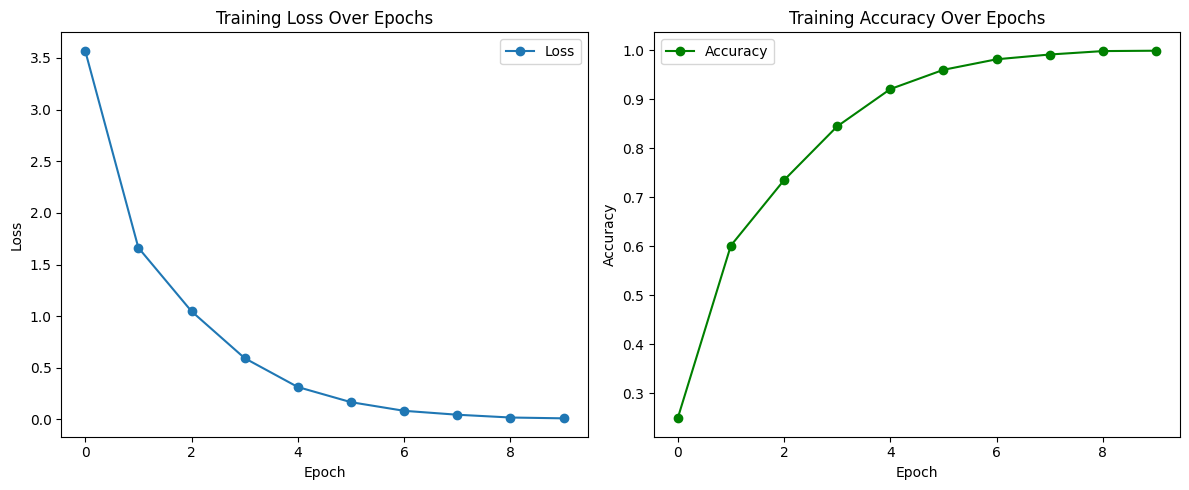

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((60, 200)),
    transforms.ToTensor(),
])

classiWords = random.sample(word_list, 100)

classification_samples = []
for word in classiWords:
    for set_type in ["easy", "hard"]:
        for _ in range(50):
            img, _ = generate_captcha(word, set_type=set_type)
            classification_samples.append((img, word))

labToIdx = {word: idx for idx, word in enumerate(classiWords)}

dataset = [(torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0, labToIdx[label])
           for img, label in classification_samples]
train_samples, test_samples = train_test_split(dataset, test_size=0.2, random_state=42, stratify=[label for _, label in dataset])

class SimpleDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = SimpleDataset(train_samples)
test_dataset = SimpleDataset(test_samples)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleCaptchaCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCaptchaCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Input image size: 60x200 → after two poolings: 15x50
        self.fc1 = nn.Linear(32 * 15 * 50, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCaptchaCNN(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

history = {"loss": [], "accuracy": []}

def train_classifier(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total

        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc)


        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

train_classifier(model, train_loader, criterion, optimizer, num_epochs=hyperparams["num_epochs"])


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["loss"], marker='o', label="Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], marker='o', color="green", label="Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix and Evaluation

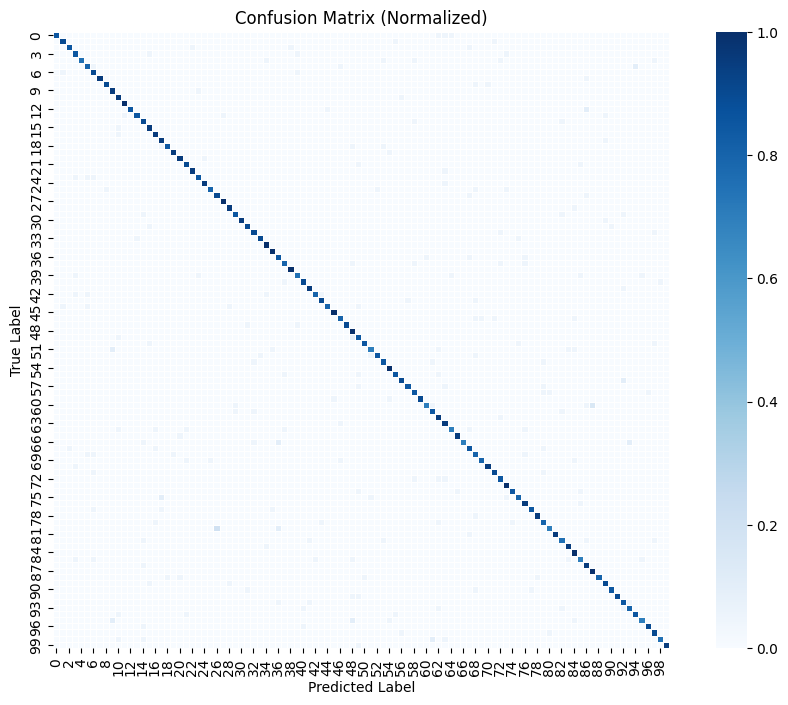

Precision: 0.8855
Recall: 0.8785
F1-score: 0.8784


In [33]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
trueLabels = []
predictedLabels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        trueLabels.extend(labels.cpu().numpy())  # Convert to list
        predictedLabels.extend(preds.cpu().numpy())

cm = confusion_matrix(trueLabels, predictedLabels)
cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-9)

#Compute Precision, Recall, F1-score
precision = precision_score(trueLabels, predictedLabels, average="macro")
recall = recall_score(trueLabels, predictedLabels, average="macro")
f1 = f1_score(trueLabels, predictedLabels, average="macro")

#Plot Confusion Matrix Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalized, annot=False, cmap="Blues", fmt=".2f", linewidths=0.5, square=True)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Task 2

In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

ocr_dataset = OCROutputDataset(num_samples=2000, set_type='hard', transform=transform)

all_ocr_samples = [ocr_dataset[i] for i in range(len(ocr_dataset))]
train_samples, test_samples = train_test_split(all_ocr_samples, test_size=0.2, random_state=42)

class SimpleOCRDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_ocr_dataset = SimpleOCRDataset(train_samples)
test_ocr_dataset = SimpleOCRDataset(test_samples)

ocr_train_loader = DataLoader(train_ocr_dataset, batch_size=64, shuffle=True)
ocr_test_loader = DataLoader(test_ocr_dataset, batch_size=64, shuffle=False)


CRNN Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, img_height=60, num_classes=27):  # 26 letters + blank
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.rnn_input_size = 128 * 15

        #BiLSTM
        self.lstm = nn.LSTM(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        #Fully connected layer
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(x.size(0), x.size(1), -1)
        #Pass through LSTM]
        x, _ = self.lstm(x)
        #Project LSTM outputs to character probabilities
        x = self.fc(x)

        x = x.permute(1, 0, 2)
        return x


Training

Epoch 1/10, Loss: 4.5242
Epoch 2/10, Loss: 3.2260
Epoch 3/10, Loss: 3.2105
Epoch 4/10, Loss: 3.2012
Epoch 5/10, Loss: 3.1814
Epoch 6/10, Loss: 3.1436
Epoch 7/10, Loss: 3.1155
Epoch 8/10, Loss: 3.0959
Epoch 9/10, Loss: 3.0797
Epoch 10/10, Loss: 3.0666


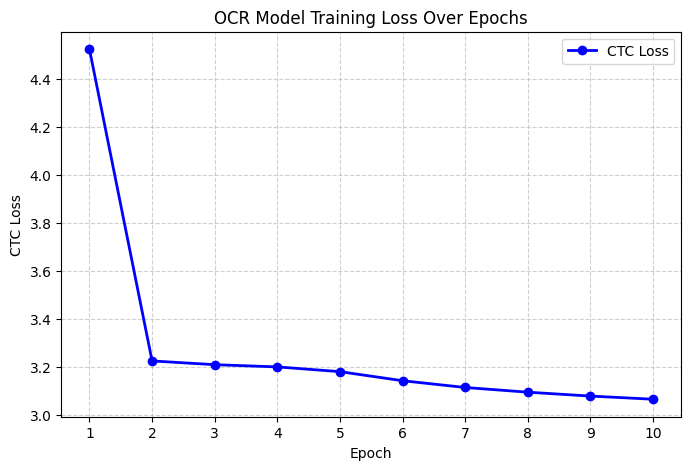

In [31]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ocr_model = CRNN(img_height=60, num_classes=27).to(device)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(ocr_model.parameters(), lr=0.0005)

lossHistory = []

def train_ocr_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        batch_count = 0

        for images, texts in dataloader:
            images = images.to(device)
            targets = []
            target_lengths = []
            for text in texts:
                indices = text_to_indices(text.lower())
                targets.extend(indices)
                target_lengths.append(len(indices))

            targets = torch.tensor(targets, dtype=torch.long).to(device)

            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)

            input_lengths = torch.full((images.size(0),), log_probs.size(0), dtype=torch.long).to(device)
            loss = criterion(log_probs, targets, input_lengths, torch.tensor(target_lengths, dtype=torch.long).to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1
        epochLoss = running_loss / batch_count
        lossHistory.append(epochLoss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epochLoss:.4f}")

#Train the model
train_ocr_model(ocr_model, ocr_train_loader, ctc_loss, optimizer, num_epochs=10)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lossHistory) + 1), lossHistory, marker='o', linestyle='-', color='blue', linewidth=2, label="CTC Loss")

#Labeling
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("OCR Model Training Loss Over Epochs")

plt.xticks(range(1, len(lossHistory) + 1))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
